# XDGMM Bovy speed test

esutil and healpy should be installed 

In [1]:
import os, sys, time
import esutil
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import time
from xdgmm import XDGMM
import warnings
warnings.filterwarnings('ignore')

In [2]:
# call required functions from modules 
sys.path.append('code_py3/')
from cmass_modules import io
from utils import matchCatalogsbyPosition, hpHEALPixelToRaDec, HealPixifyCatalogs, spatialcheck
from xd import mixing_color, doVisualization_1d, XDnew_fitting_X, XDastroML_fitting_X
from run_DMASS_Y3 import priorCut_test

# Construct training samples

We first need to load Y3 Gold catalogs in the overlapping region (training region) and split them into the cmass sample and non-cmass sample. 

In [3]:
# Calling Y3 GOLD v2.0 (training)
# All catalogs are in the 'input_path' directory 
# The 'SearchAndCallFits' function below loads all 
# catalogs in the directory including 'input_keyword' in its name
input_path = '../../data/gold_y3/'
# call only first 9 catalogs for a fast run.
# to call all catalogs in the directory, use 'Y3_GOLD' as input_keyword 
# but that will consume huge memory
#input_keyword = 'Y3_GOLD_2_0_STRIPE82_00000'  
input_keyword = 'gold_y3_stripe82_patch_00000'  
# Columns to call
columns =  ['RA', 'DEC', 
            'HPIX_4096',     # Healpix in ring order, nside=4096
            'COADD_OBJECT_ID', 
            'SOF_CM_MAG_CORRECTED_G', # mag_[griz]
            'SOF_CM_MAG_CORRECTED_R',
            'SOF_CM_MAG_CORRECTED_I',
            'SOF_CM_MAG_CORRECTED_Z',
            'SOF_CM_MAG_ERR_G',       # mag error_[griz]
            'SOF_CM_MAG_ERR_R',
            'SOF_CM_MAG_ERR_I',
            'SOF_CM_MAG_ERR_Z']
gold_st82 = io.SearchAndCallFits(path = input_path, keyword = input_keyword, columns=columns)

# Color/Magnitude cuts to exclude extremely high or low mag/color sources.
# 16 < mag_riz < 24, 0 < (r-i) < 1.5, 0 < (g-r) < 2.5
# These galaxies are less likeliy to be a CMASS, therefore unnecessary. 
# We apply these cuts to reduce the sample size to speed up the codes
mask_magcut = priorCut_test(gold_st82)
gold_st82 = gold_st82[mask_magcut]


Calling catalogs >>>
gold_y3_stripe82_patch_000002.fits
gold_y3_stripe82_patch_000001.fits
reading 1/2 ../../data/gold_y3/gold_y3_stripe82_patch_000002.fits
reading 2/2 ../../data/gold_y3/gold_y3_stripe82_patch_000001.fits


# Training the algorithm

In [11]:
# For a fast run, we draw a random sample to reduce the sample size. 
# Larger sample tends to make a better model but the sample size is not always proportional to the accuracy of the model. 

# Put sample size you want 
n_sample =  int(gold_st82.size/5)  # train cmass sample size
print('random sampling... ')
sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
gold_st82_sub = gold_st82[sampling_ind]
print('sample size =', n_sample)

random sampling... 
sample size = 33054


### Model Fitting

In [12]:
# number of gaussian mixtures
# Set None for a initial run. The algorithm automatically finds an optimal number
n_gold = None 

# number of XD iteration. 
# I set these numbers small for a fast run but generally
# should be run until the XD algorithm converges (more than 10000 iterations)
n_iter_gold = 5000
# tolerance
tol = 1E-5

# Fitted parameters and covariance will be stored as a pickle
outdir = 'output/test/fitting/'
os.makedirs(outdir, exist_ok=True)
gold_xd_astroml_filename = outdir+'gauss_gold_astroml.pkl'
gold_xd_bovy_filename = outdir+'gauss_gold_bovy.xdgmm'

In [13]:
# Magnitudes and corresponding errors you want to use to train the algorithm. 
# `mixing_color` automatically constructs [mag g, mag r, color (g-r), color (r-i)] and 
# its 4x4 covariance matrix from the input magnitudes. 
# I simply put `SOF_CM_MAG_CORRECTED` magnitudes for now. 
# If you want to use different combinations of mags and colors, 
# modify `mixing_color` or build your own function. 
mag = ['SOF_CM_MAG_CORRECTED', 'SOF_CM_MAG_CORRECTED' ]
err = ['SOF_CM_MAG_ERR', 'SOF_CM_MAG_ERR']
filter = ['G', 'R', 'I']

# This generates four columns of gold training sample. order : mag r, mag i, (g-r), (r-i)
X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                mag = mag, err=err, filter=filter, 
                no_zband = True )

### Running New XDGMM code with Bovy's method

In [27]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
from xd import _FindOptimalN_with_err
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
            pickleFileName = gold_xd_bovy_filename+'.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  26


In [28]:
# Fitting start with Bovy's method
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename, 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')

n_components= 26
fit finished. elapsed time: 11.13330602645874 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm


In [ ]:
# testing the computing time for each step

In [7]:
# Determine the best number of Gaussian Mixtures to use 
# You might not need this function as this is already included in XDnew_fitting_X()
from xd import _FindOptimalN_with_err
n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
            pickleFileName = gold_xd_bovy_filename+'.test.n_cluster' , suffix = '')

#n_cl_gold = None

@pickle_results: using precomputed results from 'output/test/fitting/gauss_gold_bovy.xdgmm.test.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  26


In [9]:
# Fitting start with Bovy's method
print ('start timing')
t1 = time.time()
clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename+'.test', 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')

t2 = time.time()-t1
print ('total elapsed time: ',t2%60, 's')  

start timing
n_components= 26
fit finished. elapsed time: 34.258455753326416 s
saving xdgmm object to..  output/test/fitting/gauss_gold_bovy.xdgmm.test
file saved
saving obj. time: 0.0008215904235839844 s
loading obj. time: 0.022568941116333008 s
total elapsed time:  34.28895831108093 s


In [ ]:
# Fitting start
# Astroml (old function) 

print ('start timing')
t1 = time.time()
clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename, 
                    n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, verbose=True)
t2 = time.time()-t1
print ('elapsed time: ',t2%60, 's')  

start timing
@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_astroml.pkl'
n components = 20
tolerance = 1e-05
1: log(L) = 26209.97902
    (4.9 sec)
2: log(L) = 26372.42825
    (4.6 sec)
3: log(L) = 26488.17967
    (4.9 sec)
4: log(L) = 26577.83265
    (4.5 sec)
5: log(L) = 26650.80533
    (4.3 sec)
6: log(L) = 26712.31656
    (4.3 sec)
7: log(L) = 26765.56881
    (4.2 sec)
8: log(L) = 26812.64402
    (4.3 sec)
9: log(L) = 26854.93545
    (4.2 sec)
10: log(L) = 26893.38328
    (4.3 sec)
11: log(L) = 26928.60231
    (4.3 sec)
12: log(L) = 26960.96182
    (4.4 sec)
13: log(L) = 26990.66527
    (4.3 sec)
14: log(L) = 27017.84231
    (4.3 sec)
15: log(L) = 27042.62725
    (4.6 sec)
16: log(L) = 27065.19544
    (4.4 sec)
17: log(L) = 27085.7581
    (4.3 sec)
18: log(L) = 27104.53987
    (4.7 sec)
19: log(L) = 27121.76118
    (4.7 sec)
20: log(L) = 27137.6321
    (4.3 sec)
21: log(L) = 27152.35384
    (4.3 sec)
22: log(L) = 27166.12188
    (4.2 sec)
23: log(L)

206: log(L) = 27831.05774
    (4.4 sec)
207: log(L) = 27831.40741
    (4.8 sec)
208: log(L) = 27831.74945
    (4.4 sec)
209: log(L) = 27832.08413
    (4.5 sec)
210: log(L) = 27832.41167
    (4.2 sec)
211: log(L) = 27832.73231
    (4.3 sec)
212: log(L) = 27833.04628
    (4.2 sec)
213: log(L) = 27833.35378
    (4.2 sec)
214: log(L) = 27833.65502
    (4.3 sec)
215: log(L) = 27833.95019
    (4.3 sec)
216: log(L) = 27834.23946
    (4.1 sec)
217: log(L) = 27834.52303
    (4.2 sec)
218: log(L) = 27834.80103
    (4.2 sec)
219: log(L) = 27835.07363
    (4.7 sec)
220: log(L) = 27835.34098
    (4.4 sec)
221: log(L) = 27835.6032
    (4.5 sec)
222: log(L) = 27835.86043
    (4.3 sec)
223: log(L) = 27836.11279
    (4.2 sec)
224: log(L) = 27836.36039
    (4.3 sec)
225: log(L) = 27836.60334
    (4.2 sec)
226: log(L) = 27836.84174
    (4.2 sec)
227: log(L) = 27837.0757
    (4.3 sec)
228: log(L) = 27837.30531
    (4.4 sec)
229: log(L) = 27837.53067
    (4.3 sec)
230: log(L) = 27837.75185
    (4.3 sec)
23

412: log(L) = 27853.3011
    (4.5 sec)
413: log(L) = 27853.34224
    (4.2 sec)
414: log(L) = 27853.38319
    (4.1 sec)
415: log(L) = 27853.42394
    (4.1 sec)
416: log(L) = 27853.46451
    (4.1 sec)
417: log(L) = 27853.50488
    (4.1 sec)
418: log(L) = 27853.54507
    (4.2 sec)
419: log(L) = 27853.58507
    (4.2 sec)
420: log(L) = 27853.62489
    (4.2 sec)
421: log(L) = 27853.66453
    (4.2 sec)
422: log(L) = 27853.70398
    (4.2 sec)
423: log(L) = 27853.74325
    (4.1 sec)
424: log(L) = 27853.78233
    (4.1 sec)
425: log(L) = 27853.82124
    (4.2 sec)
426: log(L) = 27853.85997
    (4.1 sec)
427: log(L) = 27853.89853
    (4.1 sec)
428: log(L) = 27853.93691
    (4.8 sec)
429: log(L) = 27853.97511
    (4.5 sec)
430: log(L) = 27854.01314
    (4.3 sec)
431: log(L) = 27854.051
    (4.2 sec)
432: log(L) = 27854.08869
    (4.3 sec)
433: log(L) = 27854.12621
    (4.3 sec)
434: log(L) = 27854.16355
    (4.3 sec)
435: log(L) = 27854.20073
    (4.2 sec)
436: log(L) = 27854.23775
    (4.3 sec)
437

618: log(L) = 27859.08294
    (4.3 sec)
619: log(L) = 27859.10339
    (4.4 sec)
620: log(L) = 27859.12382
    (4.2 sec)
621: log(L) = 27859.14422
    (4.5 sec)
622: log(L) = 27859.1646
    (4.4 sec)
623: log(L) = 27859.18495
    (4.2 sec)
624: log(L) = 27859.20528
    (4.2 sec)
625: log(L) = 27859.22559
    (4.3 sec)
626: log(L) = 27859.24588
    (4.3 sec)
627: log(L) = 27859.26614
    (4.1 sec)
628: log(L) = 27859.28639
    (4.2 sec)
629: log(L) = 27859.30662
    (4.2 sec)
630: log(L) = 27859.32684
    (4.3 sec)
631: log(L) = 27859.34703
    (4.4 sec)
632: log(L) = 27859.36721
    (4.3 sec)
633: log(L) = 27859.38737
    (4.2 sec)
634: log(L) = 27859.40752
    (4.2 sec)
635: log(L) = 27859.42766
    (4.2 sec)
636: log(L) = 27859.44778
    (4.3 sec)
637: log(L) = 27859.46789
    (4.2 sec)
638: log(L) = 27859.48799
    (4.3 sec)
639: log(L) = 27859.50808
    (4.2 sec)
640: log(L) = 27859.52816
    (4.2 sec)
641: log(L) = 27859.54823
    (4.2 sec)
642: log(L) = 27859.56829
    (4.2 sec)
6

824: log(L) = 27866.45307
    (4.3 sec)
825: log(L) = 27866.53621
    (4.2 sec)
826: log(L) = 27866.61958
    (4.3 sec)
827: log(L) = 27866.70315
    (4.3 sec)
828: log(L) = 27866.78691
    (4.1 sec)
829: log(L) = 27866.87083
    (4.1 sec)
830: log(L) = 27866.95491
    (4.2 sec)
831: log(L) = 27867.03912
    (4.1 sec)
832: log(L) = 27867.12346
    (4.1 sec)
833: log(L) = 27867.20791
    (4.1 sec)
834: log(L) = 27867.29245
    (4.2 sec)
835: log(L) = 27867.37709
    (4.2 sec)
836: log(L) = 27867.46182
    (4.1 sec)
837: log(L) = 27867.54662
    (4.1 sec)
838: log(L) = 27867.63149
    (4.2 sec)
839: log(L) = 27867.71643
    (4.2 sec)
840: log(L) = 27867.80144
    (4.1 sec)
841: log(L) = 27867.8865
    (4.1 sec)
842: log(L) = 27867.97164
    (4.1 sec)
843: log(L) = 27868.05684
    (4.1 sec)
844: log(L) = 27868.1421
    (4.2 sec)
845: log(L) = 27868.22745
    (4.4 sec)
846: log(L) = 27868.31287
    (4.3 sec)
847: log(L) = 27868.39838
    (4.3 sec)
848: log(L) = 27868.48398
    (4.2 sec)
84

Process Process-41255:
Process Process-41248:
Process Process-41245:
Process Process-41247:
Process Process-41246:
Process Process-41251:
Process Process-41253:
Process Process-41252:
Process Process-41254:
Process Process-41256:
Process Process-41249:
Process Process-41250:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 450, in det_process
    re = np.array([

  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 450, in det_process
    re = np.array([linalg.det(T[i]) for i in range(T.shape[0])])
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/site-packages/numpy/linalg/linalg.py", line 2159, in det
    r = r.astype(result_t, copy=False)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 450, in <listcomp>
    re = np.array([linalg.det(T[i]) for i in range(T.shape[0])])
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 450, in <listcomp>
    re = np.array([linalg.det(T[i]) for i in range(T.shape[0])])
  File "/hpc/group/cosmology/cosmosis_env/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 450, in det_process
    re = np.array([linalg.det(T[i]) for i in range(T.shape[0])])
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd

Traceback (most recent call last):
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e8976a91471e>", line 4, in <module>
    clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename,
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 851, in XDastroML_fitting_X
    clf = compute_XD(X, Xcov, init_params=init_params, n_cl = n_cl,
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/astroML/utils/decorators.py", line 105, in new_f
    retval = f(*args, **kwargs)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 839, in compute_XD
    clf.fit(X, Xcov, init_params = init_params)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 176, in fit
    logL_next = self.logL(X, Xerr)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 249, i

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e8976a91471e>", line 4, in <module>
    clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename,
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 851, in XDastroML_fitting_X
    clf = compute_XD(X, Xcov, init_params=init_params, n_cl = n_cl,
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/astroML/utils/decorators.py", line 105, in new_f
    retval = f(*args, **kwargs)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 839, in compute_XD
    clf.fit(X, Xcov, init_params = init_params)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 176, in fit
    logL_next = self.logL(X, Xerr)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 249, i

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-e8976a91471e>", line 4, in <module>
    clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename,
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 851, in XDastroML_fitting_X
    clf = compute_XD(X, Xcov, init_params=init_params, n_cl = n_cl,
  File "/hpc/home/sl661/.local/lib/python3.9/site-packages/astroML/utils/decorators.py", line 105, in new_f
    retval = f(*args, **kwargs)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 839, in compute_XD
    clf.fit(X, Xcov, init_params = init_params)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 176, in fit
    logL_next = self.logL(X, Xerr)
  File "/hpc/group/physics/sl661/DMASS-algorithm/code_py3/xd.py", line 249, i

Using precomputed results from  output/test/fitting/gauss_gold_bovy.xdgmm
Using central 100% to set range.


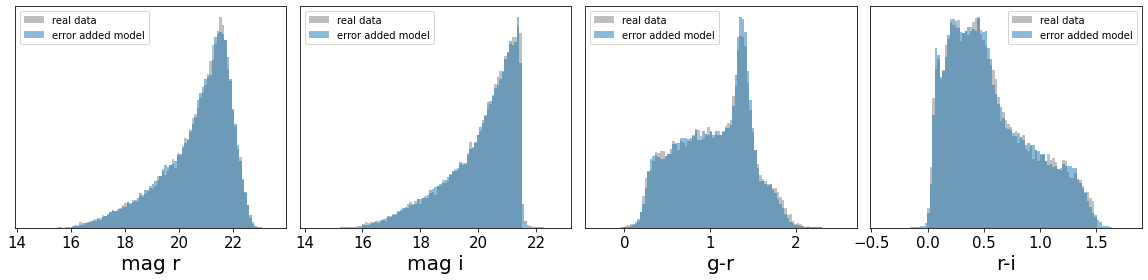

In [30]:
from xd import add_errors

# calling model
#FileName = 'output/test/fitting/gauss_gold_bovy.xdgmm'
clf_gold_bovy = XDnew_fitting_X( FileName = gold_xd_bovy_filename )
#clf_gold_astroml = XDastroML_fitting_X(FileName = gold_xd_astroml_filename)

# X_gold: real data
# X_gold_cov : error covariance assocated with data
# X_gold_model: extreme deconvolution model obtained from data (free from error)
# X_gold_model_noisy: artificial noise added to the extreme deconvolution model to make it look real data

X_gold_bovy_model = clf_gold_bovy.sample(80000)
X_gold_bovy_model_noisy = add_errors(X_gold_bovy_model, X_gold, X_gold_cov)

#X_gold_astroml_model = clf_gold_astroml.sample(20000)

# Comparison. real data vs. noise-added XD model
doVisualization_1d( data=[X_gold, X_gold_bovy_model], #, X_gold_astroml_model], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['real data', 'error added model'], 
                   weight = [None,None], 
                   nbins=100)

# Speed Test for the different size of training data

In [33]:

elapsed_time = []
# timing Bovy method for different sample size
for n_i in np.arange(1,11):
    
    gold_xd_bovy_filename_ni = gold_xd_bovy_filename+'.i{}'.format(str(n_i))
    
    # Put sample size you want 
    n_sample =  int(gold_st82.size/20 * n_i)  
    sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
    gold_st82_sub = gold_st82[sampling_ind]
    print('sample size =', n_sample)
    
    # structure data
    X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                    mag = mag, err=err, filter=filter, 
                    no_zband = True )

    # Determine the best number of Gaussian Mixtures to use 
    n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
                pickleFileName = gold_xd_bovy_filename_ni+'.n_cluster' , suffix = '')
    
    # Fitting start
    print ('start timing')
    t1 = time.time()
    clf_gold = XDnew_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_bovy_filename_ni, 
                        n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol, method='Bovy')
    t2 = time.time()-t1
    elapsed_time.append(t2)
    #print ('elapsed time: ',t2%60, 's')  
    

sample size = 8263
@pickle_results: using precomputed results from 'output/test/fitting/gauss_gold_bovy.xdgmm.i1.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  12
start timing
n_components= 12
fit finished. elapsed time: 30.981290578842163 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm.i1
sample size = 16527
@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.i2.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  22
start timing
n_components= 22
fit finished. elapsed time: 37.027477502822876 s
file saved to  output/test/fitting/gauss_gold_bovy.xdgmm.i2
sample size = 24790
@pickle_results: computing results and saving to 'output/test/fitting/gauss_gold_bovy.xdgmm.i3.n_cluster'
Finding optimal number of cluster : 100 % 
best fit converged: True  n_components =  30
start timing
n_components= 30
fit finished. elapsed time: 32.388566970825195 s
fil

In [34]:
print (elapsed_time)

[30.996947288513184, 157.06671023368835, 332.40741419792175, 419.1485526561737, 858.3061051368713, 900.7409245967865, 730.8350837230682, 1171.3625190258026, 979.1930067539215, 1601.4915063381195]


In [ ]:

elapsed_time_astroml = []
# timing Bovy method for different sample size
for n_i in np.arange(1,11):
    
    gold_xd_astroml_filename_ni = gold_xd_astroml_filename+'.i{}'.format(str(n_i))
    gold_xd_bovy_filename_ni = gold_xd_bovy_filename+'.i{}'.format(str(n_i))
    
    # Put sample size you want 
    n_sample =  int(gold_st82.size/10 * n_i)  
    sampling_ind = np.random.choice(np.arange(gold_st82.size), size = n_sample)
    gold_st82_sub = gold_st82[sampling_ind]
    print('sample size =', n_sample)
    
    # structure data
    X_gold, X_gold_cov = mixing_color(gold_st82_sub, 
                    mag = mag, err=err, filter=filter, 
                    no_zband = True )

    # Determine the best number of Gaussian Mixtures to use 
    n_cl_gold,_,_= _FindOptimalN_with_err( np.arange(2, 50, 2), X_gold, X_gold_cov, 
                pickleFileName = gold_xd_bovy_filename_ni+'.n_cluster' , suffix = '')
    
    # Fitting start
    print ('start timing')
    t1 = time.time()
    clf_gold = XDastroML_fitting_X( X_gold, X_gold_cov, FileName = gold_xd_astroml_filename_ni, 
                        n_cl = n_cl_gold, n_iter = n_iter_gold, tol = tol)
    t2 = time.time()-t1
    elapsed_time_astroml.append(t2)
    #print ('elapsed time: ',t2%60, 's')  
    

### Bovy's extreme deconvolution algorithm's computing time versus data size

In [17]:
elapsed_time=[30.996947288513184, 157.06671023368835, 332.40741419792175, 419.1485526561737, 858.3061051368713, 900.7409245967865, 730.8350837230682, 1171.3625190258026, 979.1930067539215, 1601.4915063381195]

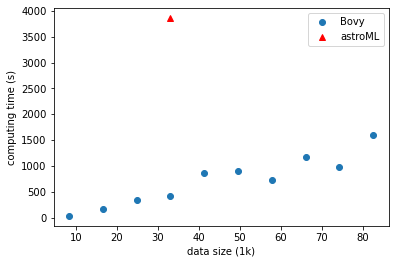

In [20]:
datasize = np.arange(1,11) * int(gold_st82.size/20)

fig, ax = plt.subplots()
ax.plot(datasize/1000, elapsed_time, 'o', label='Bovy')
ax.plot(datasize[3]/1000, 3861, 'r^', label='astroML')
ax.set_xlabel('data size (1k)')
ax.set_ylabel('computing time (s)')
ax.legend()

Using precomputed results from  output/test/fitting/gauss_gold_bovy.xdgmm.i10
Using central 100% to set range.


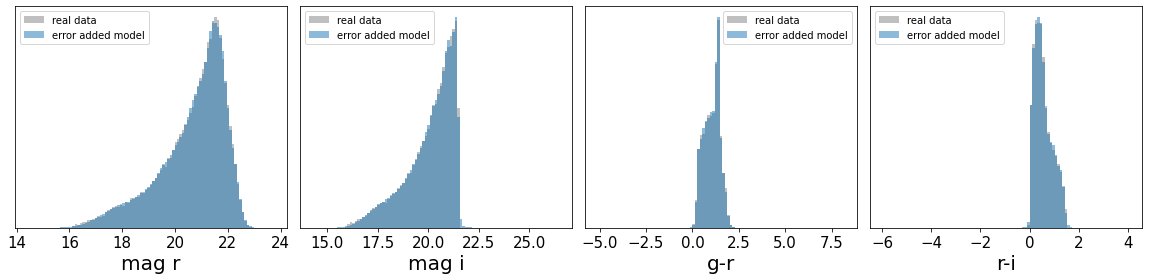

In [41]:
from xd import add_errors

# calling model
FileName = 'output/test/fitting/gauss_gold_bovy.xdgmm.i10'
clf_gold = XDnew_fitting_X( FileName = FileName )

# X_gold: real data
# X_gold_cov : error covariance assocated with data
# X_gold_model: extreme deconvolution model obtained from data (free from error)
# X_gold_model_noisy: artificial noise added to the extreme deconvolution model to make it look real data

X_gold_model = clf_gold.sample(gold_st82_sub.size)
X_gold_model_noisy = add_errors(X_gold_model, X_gold, X_gold_cov)

# Comparison. real data vs. noise-added XD model
doVisualization_1d( data=[X_gold, X_gold_model_noisy], 
                   labels = ['mag r', 'mag i', 'g-r', 'r-i'], 
                   ranges = None, 
                   name = ['real data', 'error added model'], 
                   weight = [None,None], 
                   nbins=100)